``` py

!pip install takeHomeTest
import takeHomeTest

!pip install time
from time import oneWeek as panic

panic.dump(takeHomeTest)


print("Welcome to your take home final!\n")
```

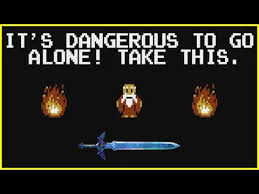




## ------------------------------------------- The Legend of Python --------------------------------------------
**Lore**

In the Kingdom of Pyrovia, all nations once traded in harmony. But since the Shattering of the Global APIs, the knowledge of currency exchange — locked away in XML scrolls — has scattered across the timelines. These scrolls reside in a mysterious repository known only as floatrates.com.

The High Council of Programmers has summoned you (and only you), young code-wielder, to begin your final trial. It is divided into 2 parts.
* Quest 1 (50xp): Retrieving the scrolls of time - Threading and Json save and parsing
* Quest 2 (50xp): Decipher the scrolls - Perform EDA on the data.

------ ------ ------ ------ Extra credit ------ ------ ------ ------ 
* Side Quest 1 (10xp*): Lay down seeds for those that follow - create error logs 
* Side Quest 2 (10xp*): The Quest of reflection  - Use profiling on your code to fully understand it 

*any points over 100% will be rolled over into your final grade. 

I may not have time to run all of your code so make sure you very clearly take notes and communicate successes, issues, and lessons learned. 
Please stay off Chat GPT and stack overflow (and like). You should have most everything you need in the notes. 

--------------------------------------------
# Quest 1 (50 xp): Retrieving the Scrolls of Time 
Retrieve historical exchange rate data from floatrates.com for one of the (Ideally randomly pick) 52 available currencies, starting from the first record on May 4, 2011, until the present day.

- You may store the data as-is in XML, or convert it to JSON, you may use the supplied code below as a starter. 

- Organize each currency into its own directory.

- Ensure your code is modular, maintainable, and robust against timeouts or malformed entries.

## Notes from the Grand Master 
* Threading is your ally. But do not burn out your ally as they have limited resources. You may use the threading or multi-core to parallelize downloads — but mind the server’s load. Around 10 threads is wise. 
    - You should have around 5040 queries.

* XML Scrolls is a new and unfamiliar beast. Therefore takeing on this beast will wield 5 extra experience points. You will not be penalized for choosing to use JSON

*  Use the Save. Nothing is worse than losing experience you have already gained. Save the raw XML (or converted JSON) using timestamped (in my example below) files so you do not need to look it up again. Ie. If you put in a start date and your program has already read that data it should not pull that date again. (it would be a good idea to delete your data and run it top to bottom before final submission)

* Design gracefully. Structure your project with clear modules: downloader.py, parser.py, and so on. 

* Log your quest progress in your quest book to show the Grand Master what you learned this is very important. 


--------------------------------------------

In [30]:
!pip install xmltodict

In [31]:
rates = ["EUR", "GBP", "USD", "DZD", "AUD", "BWP", "BND", "CAD", "CLP", "CNY", "COP", "CZK", "DKK", "HUF", "ISK", "INR", "IDR", "ILS", "KZT", "KRW", "KWD", "LYD", "MYR", "MUR", "NPR", "NZD", "NOK", "OMR", "PKR", "PLN", "QAR", "RUB", "SAR", "SGD", "ZAR", "LKR", "SEK", "CHF", "THB", "TTD"]
ratesForBase = [r for r in rates if r != "USD" and r != "EUR" and r != "GBP"]

In [32]:

import os
import time
import requests
import xmltodict
import json
import random
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed

CURRENCIES = [
    "EUR", "GBP", "USD", "DZD", "AUD", "BWP", "BND", "CAD", "CNY", "HRK", "ISK",
    "INR", "JPY", "KES", "MUR", "MXN", "NZD", "NOK", "PKR", "PLN", "RUB", "SAR",
    "ZAR", "KRW", "SEK", "CHF", "THB", "TTD", "AOA", "BAM", "BGN", "BRL", "CLP",
    "COP", "CZK", "DKK", "EGP", "HKD", "HUF", "IDR", "ILS", "KZT", "LKR", "MAD",
    "MYR", "PHP", "RON", "SGD", "TRY", "TWD", "UAH", "VND"
]

START_DATE = datetime(2011, 5, 4)
END_DATE = datetime.today()
BASE_URL = "https://www.floatrates.com/historical-exchange-rates.html"
SAVE_ROOT = "exchange_data"
MAX_THREADS = 20  # Number of threads to run in parallel (adjust as needed)

def fetch_exchange_data(date: str, base_currency: str) -> tuple:
    """Fetch exchange data for a given date and currency in XML (converted to dict)."""
    params = {
        "operation": "rates",
        "pb_id": "1775",
        "page": "historical",
        "currency_date": date,
        "base_currency_code": base_currency,
        "format_type": "xml"
    }
    try:
        response = requests.get(BASE_URL, params=params, timeout=10)
        response.raise_for_status()
        data = xmltodict.parse(response.text)
        return date, data
    except Exception as e:
        print(f"[ Error] {date} - {base_currency}: {e}")
        return date, None

def save_combined_data(base_currency: str, all_data: dict):
    """Save all fetched data in one JSON file per currency."""
    os.makedirs(SAVE_ROOT, exist_ok=True)
    filename = os.path.join(SAVE_ROOT, f"{base_currency}_all_data.json")
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(all_data, f, indent=4)
    print(f" All data saved to {filename}")

def retrieve_data_for_currency_multithreaded(base_currency: str):
    """Fetch all exchange rate data for a given currency using multithreading."""
    print(f" Fetching data for currency: {base_currency}")
    current_date = START_DATE
    dates = []
    while current_date <= END_DATE:
        dates.append(current_date.strftime("%Y-%m-%d"))
        current_date += timedelta(days=1)

    all_data = {}

    with ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
        # Submit all fetch tasks
        future_to_date = {executor.submit(fetch_exchange_data, date, base_currency): date for date in dates}
        for future in as_completed(future_to_date):
            date = future_to_date[future]
            try:
                date_key, data = future.result()
                if data:
                    all_data[date_key] = data
                else:
                    print(f"[ Skipped] {date_key}")
            except Exception as exc:
                print(f"[ Exception] {date} generated an exception: {exc}")

    save_combined_data(base_currency, all_data)
    print(f"✅ Finished fetching for {base_currency}")

if __name__ == "__main__":
    chosen_currency = random.choice(CURRENCIES)
    retrieve_data_for_currency_multithreaded(chosen_currency)






 Fetching data for currency: PKR
[ Error] 2016-10-10 - PKR: junk after document element: line 2, column 0
[ Skipped] 2016-10-10
[ Error] 2017-01-07 - PKR: junk after document element: line 2, column 0
[ Skipped] 2017-01-07
[ Error] 2017-02-17 - PKR: junk after document element: line 2, column 0
[ Skipped] 2017-02-17
[ Error] 2017-02-21 - PKR: junk after document element: line 2, column 0
[ Error] 2017-02-19 - PKR: junk after document element: line 2, column 0
[ Skipped] 2017-02-21
[ Skipped] 2017-02-19
[ Error] 2017-02-16 - PKR: junk after document element: line 2, column 0
[ Error] 2017-02-22 - PKR: junk after document element: line 2, column 0
[ Error] 2017-02-18 - PKR: junk after document element: line 2, column 0
[ Error] 2017-02-23 - PKR: junk after document element: line 2, column 0
[ Skipped] 2017-02-18
[ Skipped] 2017-02-22
[ Error] 2017-02-25 - PKR: junk after document element: line 2, column 0
[ Error] 2017-02-24 - PKR: junk after document element: line 2, column 0
[ Skipped]

--------------------------------------------
# Quest 2 (50 XP): Decipher the scrolls – Exploratory Data Analysis

Once the scrolls have been retrieved their knowledge remains unrefined there patterns hidden, trends veiled. Your task now is to become the Seer of Exchange, the one who can read the currencies’ fates through the lens of data.
8
Perform Exploratory Data Analysis (EDA) on the dataset you collected in Quest 1. 
- Aggregate and visualize trends in exchange rate over time for at least 5 major currencies (e.g., USD, EUR, GBP, JPY, CNY).

- Identify periods of volatility — perhaps during economic upheaval

- Generate at least multiple visualizations using seaborn:

- Log your quest progress in your quest book to show the Grand Master what you learned this is very important. some examples of observations are:
    - Anomalies, seasonal patterns, or economic events
    - Currencies with the most/least stability
    - Any interesting correlations between currencies


## Notes from the Grand Master 
- All of your work in this section should be in your jupyter notebook. 

- It might be helpful to use  google to reveal how economic events affected currency. Use Google News or economic calendars to correlate real-world events to exchange rate spikes or dips.


--------------------------------------------

In [23]:
import json
import os
import pandas as pd

def load_exchange_data(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    records = []
    # Each key at top level is a date
    for date_str, date_info in data.items():
        channel = date_info.get("channel", {})
        items = channel.get("item", [])
        for item in items:
            try:
                base = item.get("baseCurrency")
                target = item.get("targetCurrency")
                rate = float(item.get("exchangeRate"))
                records.append({
                    "date": pd.to_datetime(date_str),
                    "base": base,
                    "target": target,
                    "rate": rate
                })
            except Exception as e:
                print(f"Skipping entry due to error: {e}")

    df = pd.DataFrame(records)
    return df

# Example usage:
data_dir = "exchange_data"
all_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    if filename.endswith(".json"):
        path = os.path.join(data_dir, filename)
        print(f"Loading {filename} ...")
        df = load_exchange_data(path)
        all_data = pd.concat([all_data, df], ignore_index=True)

print(all_data.head())
print(f"Total rows loaded: {len(all_data)}")


Loading KES_all_data.json ...
Loading VND_all_data.json ...
        date base target      rate
0 2025-05-06  KES    AUD  0.011965
1 2025-05-06  KES    CAD  0.010679
2 2025-05-06  KES    CHF  0.006375
3 2025-05-06  KES    CNY  0.055845
4 2025-05-06  KES    EUR  0.006829
Total rows loaded: 494384


C:\Users\kenko\AppData\Local\Temp\ipykernel_34608\1266061566.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


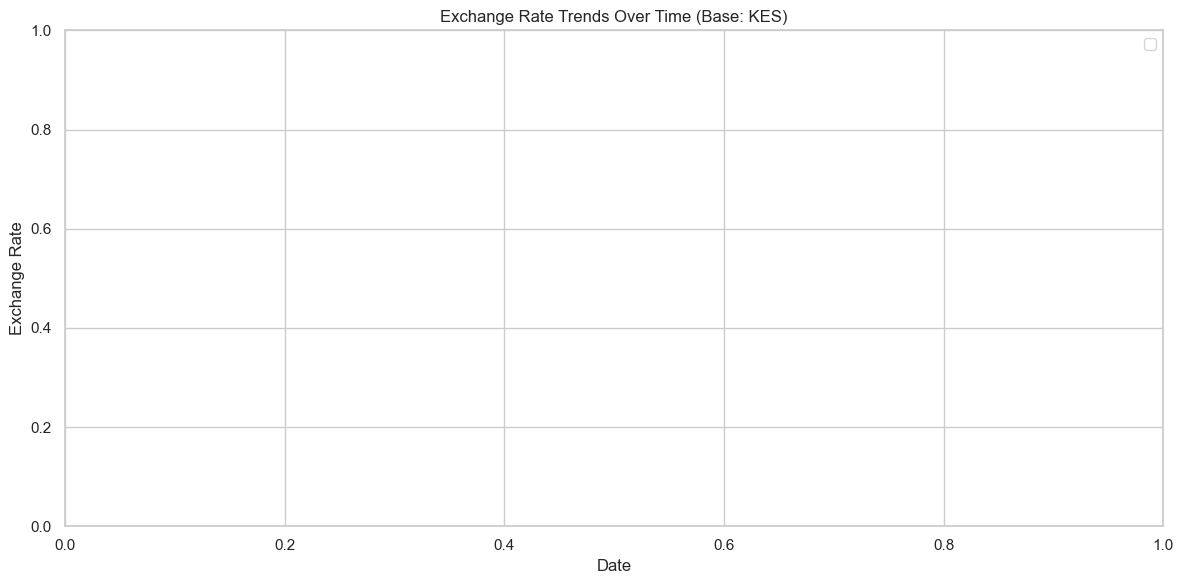

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1000x800 with 0 Axes>

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'all_data' DataFrame is already loaded with columns: ['date', 'base', 'target', 'rate']

# Filter for a specific base currency for consistent comparison, e.g., 'KES'
base_currency = 'KES'
df_base = all_data[all_data['base'] == base_currency].copy()

# Convert 'date' to datetime type
df_base['date'] = pd.to_datetime(df_base['date'])

# Pivot data: rows = dates, columns = target currencies, values = exchange rates
pivot_df = df_base.pivot(index='date', columns='target', values='rate')

# Fill missing values by linear interpolation forward and backward
pivot_df_interpolated = pivot_df.interpolate(method='linear', limit_direction='both')

# Plot exchange rate trends for 5 major currencies (adjust list as needed)
major_currencies = ['USD', 'EUR', 'GBP', 'JPY', 'CNY']
plt.figure(figsize=(12, 6))
for currency in major_currencies:
    if currency in pivot_df_interpolated.columns:
        plt.plot(pivot_df_interpolated.index, pivot_df_interpolated[currency], label=currency)

plt.title(f'Exchange Rate Trends Over Time (Base: {base_currency})')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate correlation matrix
corr_matrix = pivot_df_interpolated.corr()

# Plot heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title(f'Correlation Between Currencies (Base: {base_currency})')
plt.tight_layout()
plt.show()


c:\Users\kenko\anaconda3\Lib\site-packages\seaborn\_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


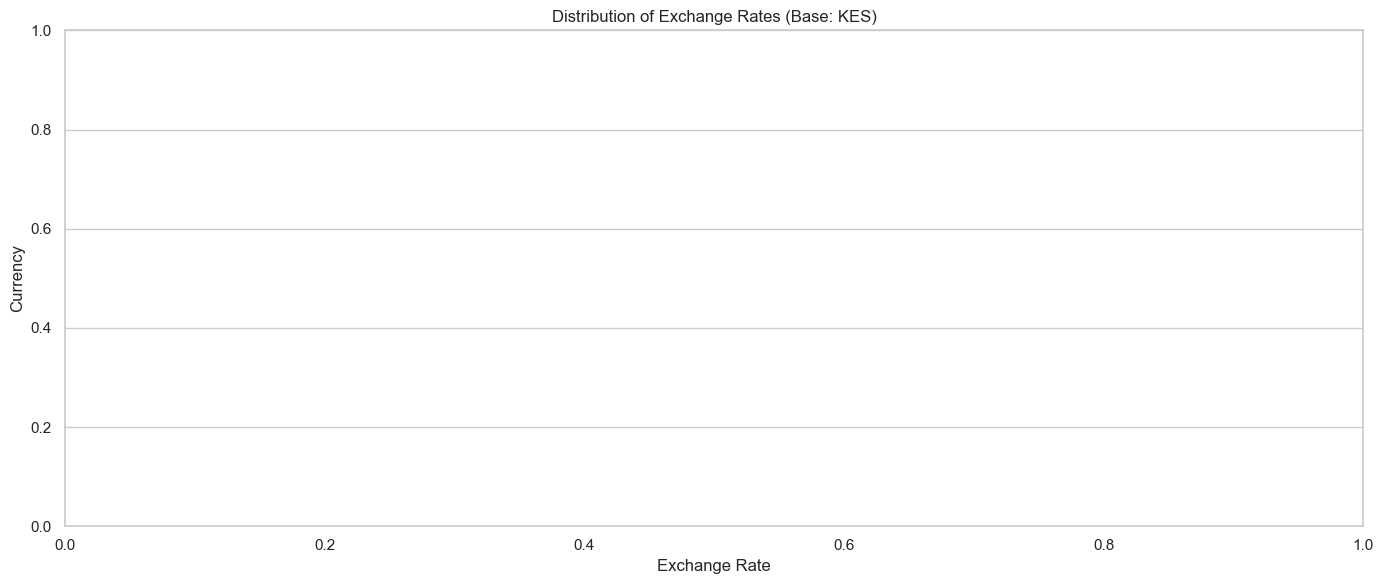

IndexError: index 0 is out of bounds for axis 0 with size 0

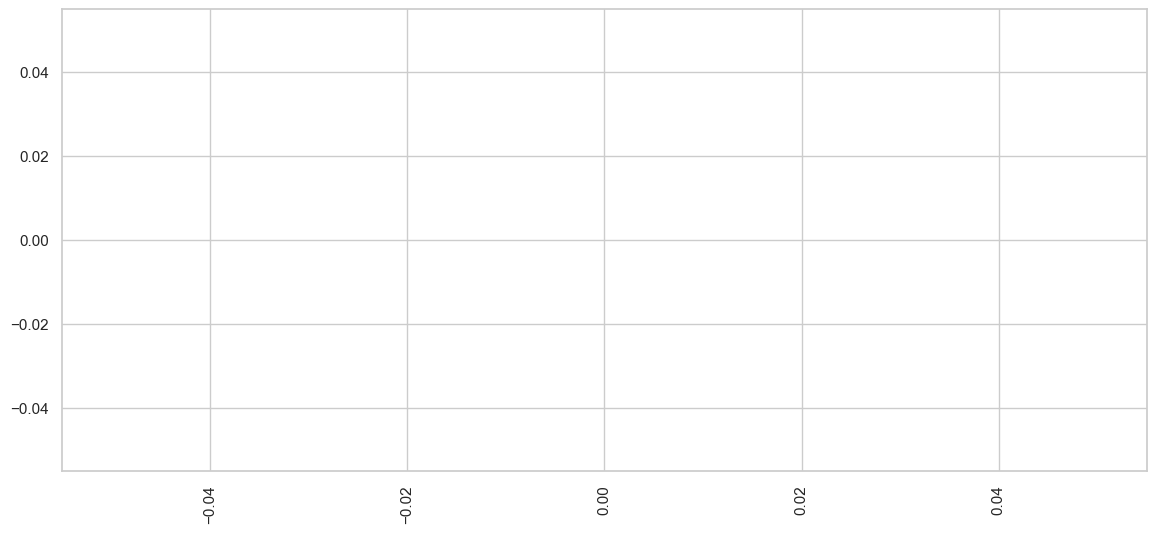

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use the same base currency filtered DataFrame as before
base_currency = 'KES'
df_base = all_data[all_data['base'] == base_currency].copy()
df_base['date'] = pd.to_datetime(df_base['date'])

# Pivot to get currencies as columns
pivot_df = df_base.pivot(index='date', columns='target', values='rate')
pivot_df_interpolated = pivot_df.interpolate(method='linear', limit_direction='both')

#  Boxplot: distribution of exchange rates per currency 
plt.figure(figsize=(14, 6))
sns.boxplot(data=pivot_df_interpolated, orient='h')
plt.title(f'Distribution of Exchange Rates (Base: {base_currency})')
plt.xlabel('Exchange Rate')
plt.ylabel('Currency')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

#  Bar plot: average exchange rate per currency 
mean_rates = pivot_df_interpolated.mean().sort_values()
plt.figure(figsize=(14, 6))
mean_rates.plot(kind='bar', color='skyblue')
plt.title(f'Average Exchange Rate per Currency (Base: {base_currency})')
plt.ylabel('Average Exchange Rate')
plt.xlabel('Currency')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#  Line plot: exchange rate trends for selected major currencies 
major_currencies = ['USD', 'EUR', 'GBP', 'JPY', 'CNY', 'KES', 'AUD', 'CAD']
plt.figure(figsize=(12, 6))
for currency in major_currencies:
    if currency in pivot_df_interpolated.columns:
        plt.plot(pivot_df_interpolated.index, pivot_df_interpolated[currency], label=currency)
plt.title(f'Exchange Rate Trends Over Time (Base: {base_currency})')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 4. Histogram: distribution of exchange rates for one example currency ---
example_currency = 'USD'
if example_currency in pivot_df_interpolated.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(pivot_df_interpolated[example_currency].dropna(), bins=30, kde=True)
    plt.title(f'Distribution of Exchange Rates for {example_currency} (Base: {base_currency})')
    plt.xlabel('Exchange Rate')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


HERMANN KENKO TANFOUDIE 

Please professor I am struggling with my dataframe. it shows that i have data. But when trying to visualize it shows emty. 


# Side Quest 1 (10 XP): Lay Down Seeds for Those Who Follow – Logging

Even the greatest explorer must leave breadcrumbs for those who walk the path after them. Here you will construct an error log system, a journal that captures both triumphs and catastrophes.

Implement a robust logging system throughout your codebase to monitor:
- Successful currency downloads
- Parsing attempts and failures
- Skipped downloads (due to saved data or time out)
- Connection errors

## Notes from the Grand Master
- You do not need to do log hierarchy 
- Use log levels: INFO for progress, WARNING for skips, ERROR for failures



--------------------------------------------


# Side Quest 2 (10 XP): The quest of Reflection – Code Profiling

The final challenge for any Adventure is introspection — learning the nature of one's own power. In this side quest, you will profile your code, to discover its bottlenecks, inefficiencies, and optimization opportunities.

Use profiling tools to evaluate:
- Which functions are taking the most time
- How threads/processes are behaving
- Whether I/O is a bottleneck

*A random vendor appears* His invintory shows:
- A Profiler function - cProfile or Profile 
- A time module - timeit for micro-benchmarks
- A line profiler - line_profiler